In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import json
import requests
import pickle
import glob
from datetime import datetime
from ast import literal_eval as make_tuple

from functions.util import get_trade, get_prod

## Setup

In [2]:
sns.set_style("whitegrid")

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Countries we want to import
countries = ['DE','CH','AL','AM','AT','AZ','BA','BE','BG','BY','CY','CZ','DK','EE','ES','FI','FR','GE','GR','HR','HU','IE','IT','LT','LU','LV','MD','ME','MK','MT','NIE','NL','NO','PL','PT','RO','RS','RU','SE','SI','SK','TR','UA','UK','XK']

## Scraping the data
Please don't run this part if you already have saved the time series you need. This is bandwidth-consuming (mostly for the server side). The data is publicly available from https://energy-charts.info, which is an amazing visualisation website, not a data repository.

In [5]:
glob.glob('./*')

['.\\eia_api_token.txt',
 '.\\eia_charts.ipynb',
 '.\\electricity_prices.ipynb',
 '.\\electricity_trade.ipynb',
 '.\\energy_charts.ipynb',
 '.\\entsoe_api_token.txt',
 '.\\functions',
 '.\\generation_units_by_country.csv',
 '.\\GHG_vs_prod_US.png',
 '.\\MATERIALS.xlsx',
 '.\\output',
 '.\\plant_level_analysis.ipynb',
 '.\\plot_3d_mayavi.ipynb',
 '.\\prod_3d_plot.ipynb',
 '.\\prod_and_trade_data.pickle',
 '.\\prod_and_trade_data_2021.pickle',
 '.\\README.md',
 '.\\__pycache__']

In [6]:
if  '.\\prod_and_trade_data.pickle' in glob.glob('./*'):
    
    f = open('prod_and_trade_data.pickle', 'rb')
    data = pickle.load(f)
    
else:
    
    # Data grab
    data = dict()
    year = '2021'

    for country in countries:
        country = country.lower()

        print(country)
        prod_df, _, _ = get_prod(country=country, # country code
                                        step='hour',
                                 year=year,  # year
                                 display=False, # display chart (or just save data)
                                 load=True,    # show load
                                 cumul=False,  # cumulative
                                 rolling=1,   # rolling average, in timesteps
                                 lang='en')    # language
        print('...production OK')

        trade_df, _ = get_trade(year=year,
                                country=country,
                                lang='en',
                                display=False)
        print('...trade OK')

        data[country] = {'production mix': prod_df,
                         'trade': trade_df}

    f = open('prod_and_trade_data.pickle', 'wb')
    pickle.dump(data , f)

## Making sense of the collected data
It would be too nice if all data were harmonised, of course it is not. Let's first collect the full list of technologies and trade partners.

In [7]:
techs = []
partners = []

for country, datasets in data.items():
    try:
        techs.extend(datasets['production mix'].columns)
        partners.extend(datasets['trade'].columns)
    except:
        pass

In [8]:
# This is only to get the country codes, we don't use the rest of the file
gen_units_per_country = pd.read_csv('generation_units_by_country.csv', index_col=1)['short']

In [9]:
country_codes = {p: gen_units_per_country.loc[p] for p in set(partners) if p in gen_units_per_country.index}

In [10]:
# What are we missing?
set(partners) ^ country_codes.keys()

{'Armenia',
 'Azerbaijan',
 'Ireland',
 'Malta',
 'North Macedonia',
 'Serbia',
 'sum'}

In [11]:
# Add the remaining countries by hand... this will also exclude "sum" from the trade data
country_codes = {**country_codes, **{'Armenia':'AM',
                                     'Azerbaijan':'AZ',
                                     'Ireland':'IE',
                                     'Malta':'MT',
                                     'North Macedonia':'MK',
                                     'Serbia':'RS'}}

The list of techs is not unique, muhaha.

In [12]:
techs_agg = {'Hydro pumped storage consumption': 'Hydro pumped storage consumption',
               'Import Balance': 'Import balance',
               'Biomass': 'Biomass',
               'Fossil gas': 'Fossil gas',
               'Fossil oil': 'Fossil oil',
               'Fossil oil shale': 'Fossil oil shale',
               'Fossil peat': 'Fossil peat',
               'Hydro pumped storage': 'Hydro pumped storage generation',
               'Hydro Pumped Storage': 'Hydro pumped storage generation',
               'Hydro Run-of-River': 'Hydro run-of-river',
               'Nuclear': 'Nuclear',
               'Others': 'Others',
               'Solar': 'Solar',
               'Waste': 'Waste',
               'Wind offshore': 'Wind',
               'Wind onshore': 'Wind',
               'Pumped Storage consumption': 'Hydro pumped storage consumption',
               'Hydro Power': 'Hydro',
               'Uranium': 'Nuclear',
               'Brown Coal': 'Brown coal',
               'Other renewables': 'Other renewables',
               'Hard Coal': 'Hard coal',
               'Oil': 'Fossil oil',
               'Gas': 'Fossil gas',
               'Pumped Storage generation': 'Hydro pumped storage generation',
               'Wind': 'Wind',
               'Hydro Pumped Storage consumption': 'Hydro pumped storage consumption',
               'Fossil Brown Coal': 'Brown coal',
               'Fossil brown coal / lignite': 'Brown coal',
               'Fossil Hard Coal': 'Hard coal',
               'Fossil Oil': 'Fossil oil',
               'Fossil Gas': 'Fossil gas',
               'Fossil coal-derived gas': 'Fossil coal-derived gas',
               'Hydro Pumped Storage generation': 'Hydro pumped storage generation',
               'Hydro Water Reservoir': 'Hydro',
               'Hydro water reservoir': 'Hydro',
               'Geothermal': 'Geothermal',
               'Fossil hard coal': 'Hard coal'}

In [13]:
# Now let's check the shape of the various tables we have
for country in data.keys():
    
    for kk,vv in data[country].items():
        
        if vv is not None:
            print(country,kk,vv.shape)

de production mix (35040, 14)
de trade (35037, 12)
ch production mix (8760, 8)
ch trade (35037, 5)
al production mix (35040, 1)
al trade (8760, 4)
am trade (8760, 2)
at production mix (35040, 12)
at trade (35037, 7)
az trade (8760, 2)
ba production mix (8760, 8)
ba trade (8760, 4)
be production mix (8760, 13)
be trade (35037, 6)
bg production mix (8760, 13)
bg trade (8760, 6)
by trade (8760, 3)
cy production mix (17520, 3)
cz production mix (8760, 17)
cz trade (8760, 5)
dk production mix (8760, 9)
dk trade (35037, 5)
ee production mix (8760, 11)
ee trade (8760, 4)
es production mix (8760, 13)
es trade (8760, 3)
fi production mix (8760, 12)
fi trade (8760, 5)
fr production mix (8760, 13)
fr trade (8760, 7)
ge production mix (8760, 5)
ge trade (8760, 5)
gr production mix (8760, 5)
gr trade (8760, 6)
hr production mix (8760, 14)
hr trade (8760, 5)
hu production mix (35040, 15)
hu trade (35037, 7)
ie production mix (17520, 10)
ie trade (8760, 2)
it production mix (8760, 15)
it trade (8760,

## Cleaning
The next steps are cleaning steps:
    - aggregate technology names into the single set of names we defined,
    - match country names with their unique code,
    - scale the values, trade is in MWh while production is in GWh (except Germany, God knows why).

In [14]:
data_clean = dict()
agg_dict = {'production mix': techs_agg,
            'trade': country_codes}
scale_dict = {'production mix': 1,
              'trade': 1000}

for country in data.keys():
    
    data_clean[country.upper()] = dict()
    
    for k,v in data[country].items():
        
        if v is not None:
            data_clean[country.upper()][k] = v.groupby(agg_dict[k], axis=1).sum().resample("h").mean() * scale_dict[k]
            
            if country=='de' and k=='production mix':
                data_clean[country.upper()][k] *= 1000


## Treatment
Now we will actually use the data for our objectives.

In [15]:
# Lots of concatenation to obtain a single dataframe containing all the data we want
P = pd.concat([pd.concat({country: pd.concat(data_clean[country], axis=1)}, axis=1, names=['country','type','source']) for country in data_clean.keys()], axis=1)

In [16]:
# For the production-consumption adjustment, we have to pick a given hour in the year.
hour=4000

T = P.iloc[hour].unstack('country').fillna(0)
time=P.index[hour]

<AxesSubplot:xlabel='country', ylabel='type-source'>

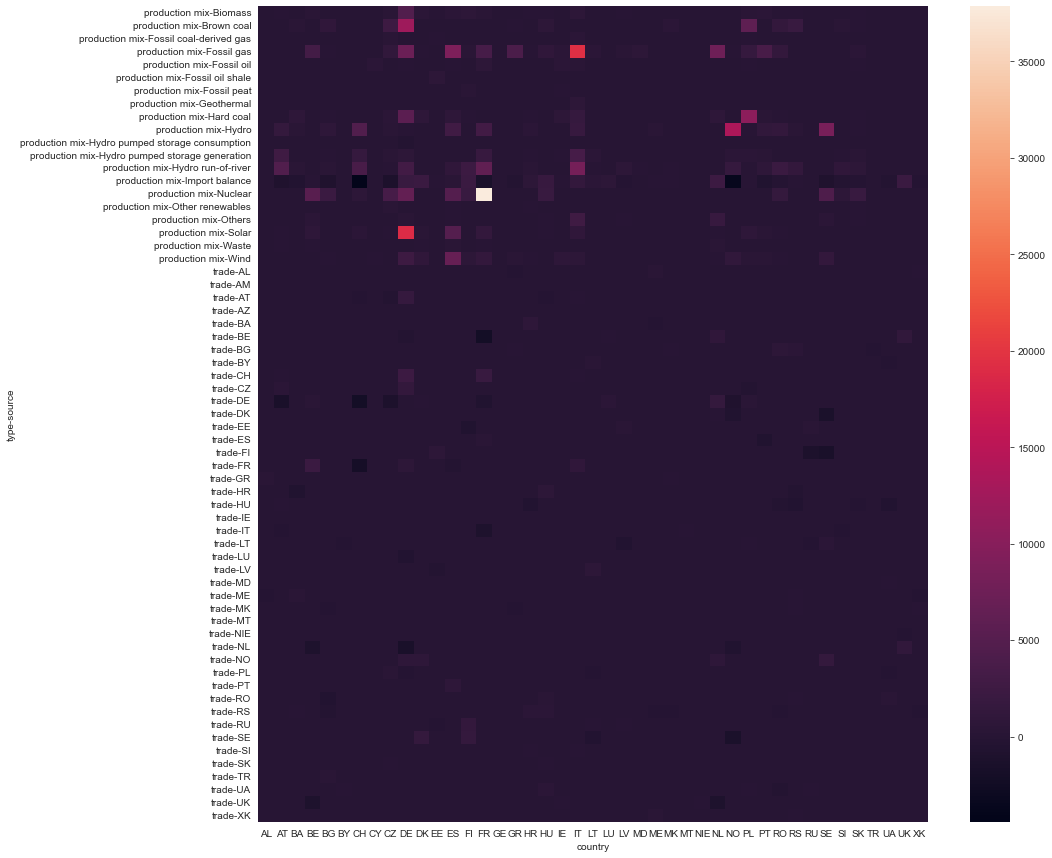

In [17]:
# So what happened on that hour? Let's make a heatmap
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(T, ax=ax)

In [18]:
# Drop import balance as it's already accounted for in the trade matrix (we can check that it matches actually, plot twist: it does, except for Germany)
T.drop(('production mix', 'Import balance'), inplace=True)

In [19]:
# Get the full index of countries, the union set of columns (importers) and indices (exporters)
full_index = T.columns | T.loc['trade'].index

In [20]:
# Make T square again
T_sq = T.reindex(full_index, axis=1)

# Exports are already accounted for as imports (their off-diagonal counterparts)
T_sq.loc['trade'][T_sq.loc['trade'] < 0] = 0

# Now build the P matrix, containing share data
P_prod = (T_sq.loc['production mix']/T_sq.sum()).fillna(0)
P_trade = (T_sq.loc['trade'].reindex(full_index)/T_sq.sum()).fillna(0)

In [21]:
# The almighty matrix inversion
L_trade = pd.DataFrame(np.linalg.inv(np.eye(P_trade.shape[0]) - P_trade), index=P_trade.index, columns=P_trade.columns)

In [22]:
# The consumption mix equals the production mixes multiplied by the "full cycle"/resolved graph network
M = P_prod.dot(L_trade)

In [23]:
comparison = pd.concat([P_prod, M], axis=1, keys=['production','consumption']).sort_index(axis=1, level=1).swaplevel(axis=1)

<AxesSubplot:title={'center':'Production and consumption mixes on 2021-06-16 15:00:00 GMT'}>

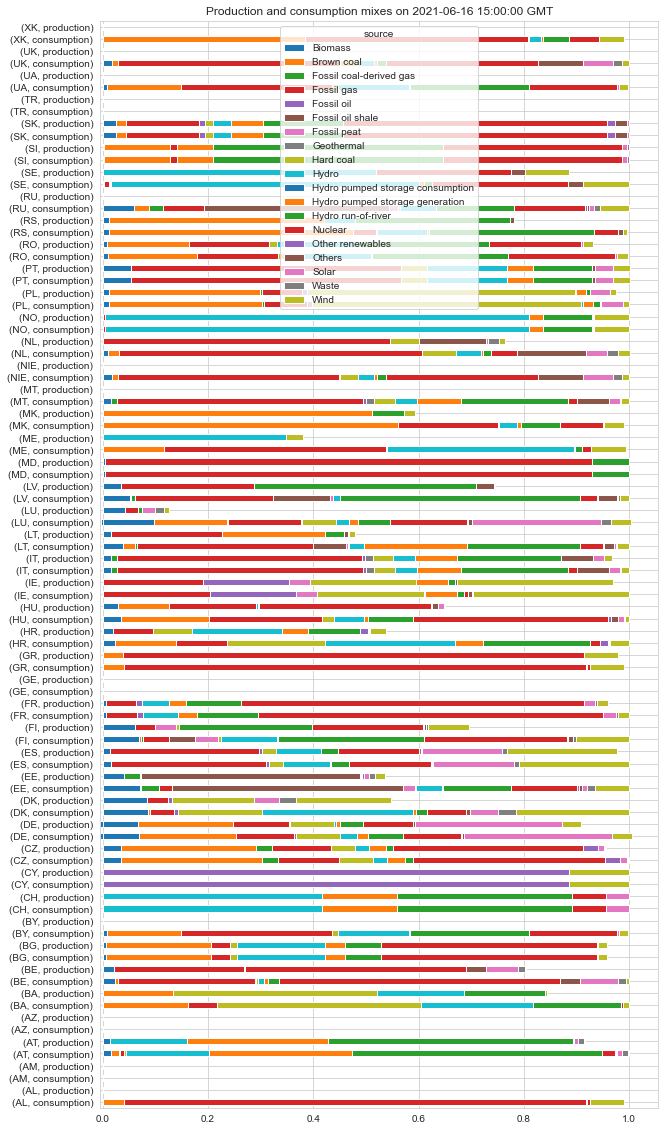

In [24]:
comparison.T.plot.barh(stacked=True, figsize=(10,20), title=f'Production and consumption mixes on {time} GMT')